
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import numpy as np
import pandas as pd
from sys import exit
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector


In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [6]:
#KNN
X = ha.drop(columns=["cp",'output'])
y = ha["cp"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, drop = "first", handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_preds = cross_val_predict(lr_pipeline, X, y, cv=5)

print("KNN Classification Report:")
print(classification_report(y, knn_preds))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       128
           1       0.13      0.11      0.12        44
           2       0.32      0.22      0.26        81
           3       0.20      0.05      0.08        20

    accuracy                           0.40       273
   macro avg       0.29      0.26      0.26       273
weighted avg       0.36      0.40      0.37       273



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.74      0.64       128
           1       0.00      0.00      0.00        44
           2       0.35      0.44      0.39        81
           3       0.00      0.00      0.00        20

    accuracy                           0.48       273
   macro avg       0.23      0.30      0.26       273
weighted avg       0.37      0.48      0.42       273



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


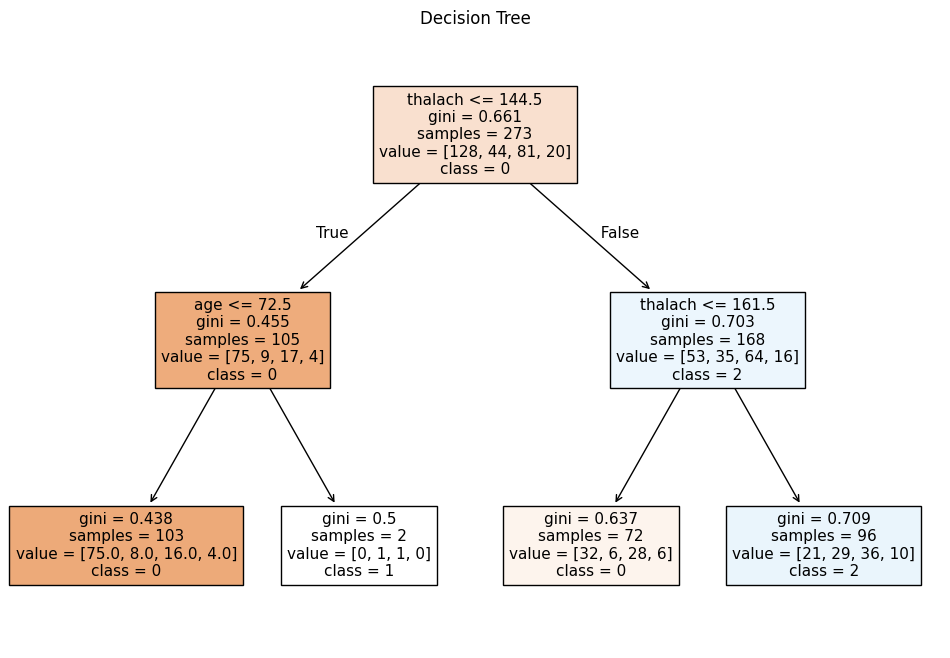

In [7]:
#Decision Tree
dt = DecisionTreeClassifier(max_depth=2)

dt_preds = cross_val_predict(dt, X, y, cv=5)

print("Decision Tree Classification Report:")
print(classification_report(y, dt_preds))

# Fit the model on the entire dataset for plotting
dt.fit(X, y)

# Plot the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in dt.classes_], filled=True)
plt.title("Decision Tree")
plt.show()


The first split uses the feature thalach to broadly separate the data into two groups based on heart rate thresholds.  
The left subtree focuses on refining predictions for lower thalach values using age, while the right subtree further divides higher thalach values.  
These splits aim to reduce the Gini impurity, improving classification accuracy at each level.

In [8]:
#LDA
lda = LinearDiscriminantAnalysis()

# Cross-validated predictions
lda_preds = cross_val_predict(lda, X, y, cv=5)

# Evaluation
print("LDA Classification Report:")
print(classification_report(y, lda_preds))


LDA Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       128
           1       0.40      0.05      0.08        44
           2       0.32      0.36      0.34        81
           3       0.00      0.00      0.00        20

    accuracy                           0.47       273
   macro avg       0.32      0.29      0.26       273
weighted avg       0.42      0.47      0.41       273



## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [9]:
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

In [10]:
X = ha.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha["cp_is_3"]

In [11]:
model1 = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model1, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        20

    accuracy                           0.92       273
   macro avg       0.46      0.50      0.48       273
weighted avg       0.86      0.92      0.89       273



The F1 score for cp not equal to 3 is 0.96, while the F1 score for cp equal to 3 is 0.00. This indicates that the model performs very well when cp is not 3 but fails completely to identify cases where cp is 3.

In [12]:
y = ha["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       145
           1       0.64      0.56      0.60       128

    accuracy                           0.64       273
   macro avg       0.64      0.64      0.64       273
weighted avg       0.64      0.64      0.64       273



The F1 score for cp not equal to 0 is 0.68, while the F1 score for cp equal to 0 is 0.60. This indicates that the model performs well when cp is not 0 and cp is 0.

In [13]:
y = ha["cp_is_1"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       229
           1       0.00      0.00      0.00        44

    accuracy                           0.83       273
   macro avg       0.42      0.50      0.45       273
weighted avg       0.70      0.83      0.76       273



The F1 score for cp not equal to 1 is 0.91, while the F1 score for cp equal to 1 is 0.00. This indicates that the model performs very well when cp is not 1 but fails completely to identify cases where cp is 1.

In [14]:
y = ha["cp_is_2"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       192
           1       0.17      0.05      0.08        81

    accuracy                           0.65       273
   macro avg       0.43      0.48      0.43       273
weighted avg       0.54      0.65      0.57       273



The F1 score for cp not equal to 2 is 0.78, while the F1 score for cp equal to 2 is 0.08. This indicates that the model performs very well when cp is not 2 but fails to identify cases where cp is 2.

The OvR approach works best when cp = 0 is the category, as it has the highest F1 score for category 0.


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [15]:
ha_0_1 = ha[~ha['cp'].isin([2, 3])]
X = ha_0_1.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])

In [16]:
y = ha_0_1["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 1: {roc_auc_score(y, y_pred)}")

roc_auc_score for 0 and 1: 0.6235795454545454


In [17]:
ha_0_2 = ha[~ha['cp'].isin([1, 3])]
X = ha_0_2.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha_0_2["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 2: {roc_auc_score(y, y_pred)}")

roc_auc_score for 0 and 2: 0.5719039351851852


In [18]:
ha_0_3 = ha[~ha['cp'].isin([1, 2])]
X = ha_0_3.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha_0_3["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 3: {roc_auc_score(y, y_pred)}")

roc_auc_score for 0 and 3: 0.4765625


# Sources
Assistance was provided by ChatGPT and Gemini for guidance on coding functions, analysis suggestions, and code fixing.